# Chapter 2 - Cross References: Shapes of Knowledge in Chambers's _Cyclopaedia_ 

This is the notebook for chapter one in which I transform Ephraim Chambers's "View of Knowledge" diagram and catalogs of entries into word vectors that are visualized according to the semantic similarity scores. I also examine the entries listed under all the arts and sciences according to their average similarity scores. The word vector model was trained on the manually transcribed texts of the _Early English Books Online_ and _Eighteenth-Century Collections Online_ "Text Creation Partnership" files from 1660 to 1740. As I explain below and in the chapter at length, the point of this analysis was to examine how Chambers's encylopedic system of knowledge transformed the meaning of terms of art and sciences from the everyday usage in print. 

In [38]:
#import gensim
import random
import numpy as np
from gensim.models import Word2Vec ## Make sure this works?
from collections import Counter
from collections import defaultdict
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Load `word2vec` model and _Cyclopaedia_ data 

In [2]:
#from gensim.models.deprecated.word2vec import load_old_word2vec


rest_model = Word2Vec.load('newRestModel-21')

### Basic vector addition to observe how the model works

In [3]:
rest_model.wv.most_similar(positive=['france', 'london'], negative=['england'])

[('paris', 0.6749070882797241),
 ('antwerp', 0.6736378073692322),
 ('brussels', 0.6647899746894836),
 ('roan', 0.6496724486351013),
 ('burse', 0.6392587423324585),
 ('sienna', 0.6358257532119751),
 ('warsaw', 0.6317530274391174),
 ('hostel', 0.6243134140968323),
 ('madrid', 0.6146501898765564),
 ('stockholm', 0.6109710931777954)]

In [4]:
rest_model.wv.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.6856386661529541),
 ('dowager', 0.6401495933532715),
 ('queens', 0.6339358687400818),
 ('eleanor', 0.6298878192901611),
 ('catherine', 0.6198285818099976),
 ('dauphin', 0.6073744297027588),
 ('katharine', 0.5963516235351562),
 ('daughter', 0.5947338342666626),
 ('catharine', 0.5941138863563538),
 ('blanch', 0.5934325456619263)]

### What is the Cyclopaedia data I'm loading 
Here I import several different data structures that organize features of the _Cyclopaedia_. 

1. `headings` - dictionary with each art and science as a key. The values are the entries listed in the summary catalogs of entries that Chambers's printed in the "Preface." As Chambers notes, the summary catalogs do not include every entry that falls under each art and science. The catalogs represent a distilled view of the disciplines and suggest a course through the discipline that could be traced using the cross-references. 
2. `linkOrder`- a list of all the arts and sciences. 
3. `diagramCategories` - dictionary with each category of art and science included in Chambers's "View of Knowledge" tree diagram in the preface. The values are lists of the arts and sciences that fall under each category. 
4. diagram2

In [5]:
from chambersTerms import headings 
from chambersTerms import linkOrder
from chambersTerms import diagramCategories


In [36]:
from collections import Counter
#Counter(diagramCategories.items())

## Creating reference diagrams

### Similarity diagram

In [21]:
missingHeaders =[]
termVecs = []
refinedEntries = [] 
for term in entryList:
    if term in rest_model.wv:
        refinedEntries.append(term)
        termVecs.append(rest_model.wv[term])
    else:
        missingHeaders.append(term)
combVecs = []  
for lab, vec in zip(refinedEntries, termVecs): 
    combVecs.append((lab, vec))
selectVecs = random.sample(combVecs, 100)

NameError: name 'entryList' is not defined

In [28]:
len(missingHeaders)

610

In [28]:
selLabs = [] 
selVecs = [] 
for (lab, vec) in selectVecs: 
    selLabs.append(lab)
    selVecs.append(vec)

In [186]:
vecMat = np.array(selVecs)

In [187]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(vecMat)

### Similarity Diagram

In [23]:
import time

In [6]:
#help(time)

In [24]:
t0 = time.time()
entryList =  [t for k, v in headings.items() for t in v ]
for k in headings.keys(): 
    entryList.append(k)
print(time.time()-t0)

0.00027489662170410156


In [25]:
### List of all the discipline and entry terms included in the diagram and summary catalogs of the preface. 
len(list(set(entryList))) ## *** It may help to recreate the graph with duplicates removed


2393

In [26]:
t= time.time()
termPairs = [] 
#relationList = [] 
for idx1, term in enumerate(entryList): 
    for idx2, term2 in enumerate(entryList):
        if idx2>idx1 and term in rest_model.wv.index_to_key and term2 in rest_model.wv.index_to_key: 
            sim = rest_model.wv.similarity(term, term2)
            if sim > 0.4: ## tweaking parameters
            #relationList.append(relation)
                termPairs.append((term, term2, sim))
print(time.time()-t0)

3228.394998073578


The `termPairs` variable is a list of tuples that stores the similarity score between entries and discipline terms for pairs with scores above 0.4. The higher the value the greater the semantic similarity between the terms. The value is used to create edges between the terms as nodes for visualizing the Chambers's terms as a network. The point here is to observe how the word vector model transforms the relationships between terms. The model reflects similarities between terms based on how they were used across 17th- and 18th-century print. As a result, the visualization represents Chambers's network of knowledge rearranged according to how language was actually used in the period. It allows viewers to examine how Chambers's system removed terms of art and science from their common usage. 

In [28]:
termPairs = pickle.load(open('termPairs.p', 'rb'))
print(termPairs[5])

In [34]:
G = nx.Graph()
for i in termPairs:
    wt = i[2]#*20
    G.add_edge(i[0], i[1], weight=wt)
pos = nx.kamada_kawai_layout(G) 

In [40]:
nodes = []
degrees = [] 
for node in G.nodes(): 
    node_degree = 0 
    for edge in G.edges(): 
        if node in edge: 
            node_degree += 1
    node_degree = node_degree*50
    degrees.append(node_degree)
    nodes.append(node)

Run the [Louvain community detection](https://python-louvain.readthedocs.io/en/latest/) algorithm to observe clusters of related entries. 

In [42]:
from networkx import community
part = community.louvain_communities(G)

In [43]:
values = [i for node in G.nodes() for i, lst in enumerate(part) if node in lst]
clustDict = defaultdict(list)
for w, clus in zip(nodes, values): 
    clustDict[clus].append(w)

Here's a description of the communities I identified when I ran the algorithm for the book. 
- 0: Medicine/pharmacy anatomy
- 1: Law and policy (with a bunch of terms from commerce)
- 2: Military, fortification, agriculture/gardening, commerce, manufactures
- 3: Abstract/symbolic arts - poetry, rhetoric, ethics, metaphysics, logic 
- 4: Mathematics - astronomy, algebra, arithmetic, geometry, dialling, perspective

In [44]:
### Organize the communities data for the visualization. 
headClusters = defaultdict(list)
clustWords = defaultdict(list)
for h in headings.keys():
    count = 0 
    for w in clustDict[1]: 
        if w in headings[h]: 
            count+=1 
            clustWords[h].append(w)
    if count > 0: 
        headClusters[h] = count    

These are lists for filtering the visualization. I cut some terms to increase the legibility, and I add terms that I want to draw attention to in the book. You can alter the lists depending on what relationships between entries you want to explore.

In [45]:
cutList =['sequestration', 'column', 'gems','excellence', 'urine', 'echo', 'sterling', 'proper', 'horizontal', 'difference', 'algebra', 
         'fallacy', 'antithesis', 'figures', 'characters', 'assent', 'volatility', 'perpendicular', 'glass', 'abbot', 'transported', 'systems', 'bog', 'dissolution', 'exchequer', 'stoicism']
addSmall = ['colony', 'slave', 'tragedy', 'association', 'woollen', 'woolen', 'company', 'pike', 'comedy', 'tenants', 'excommunication', 'franchise', 'drug',
           'vessels', 'syllable', 'spirit', 'elegy', 'jury', 'manumission', 'admiral', 'bubble', 
           'confection', 'syrup', 'god', 'king', 'soldier', 'ship', 'crest', 'heaven', 'spice', 
           'satire', 'melodoy', 'assurance', 'dignities', 'equity', 'inca', 'affadavit', 'impost',
           'commons', 'lords', 'poundage', 'anchor', 'frigate']
addList =['military', 'metaphysics', 'physics', 'commerce', 'rhetoric', 'poetry', 'pharmacy', 'theology', 'geometry',
         'ethics', 'law', 'anatomy', 'medicine', 'perspective', 'sculpture', 'painting', 
         'architecture', 'navigation', 'pyrotechny', 'logic']

## Visulize the similarity network

No handles with labels found to put in legend.


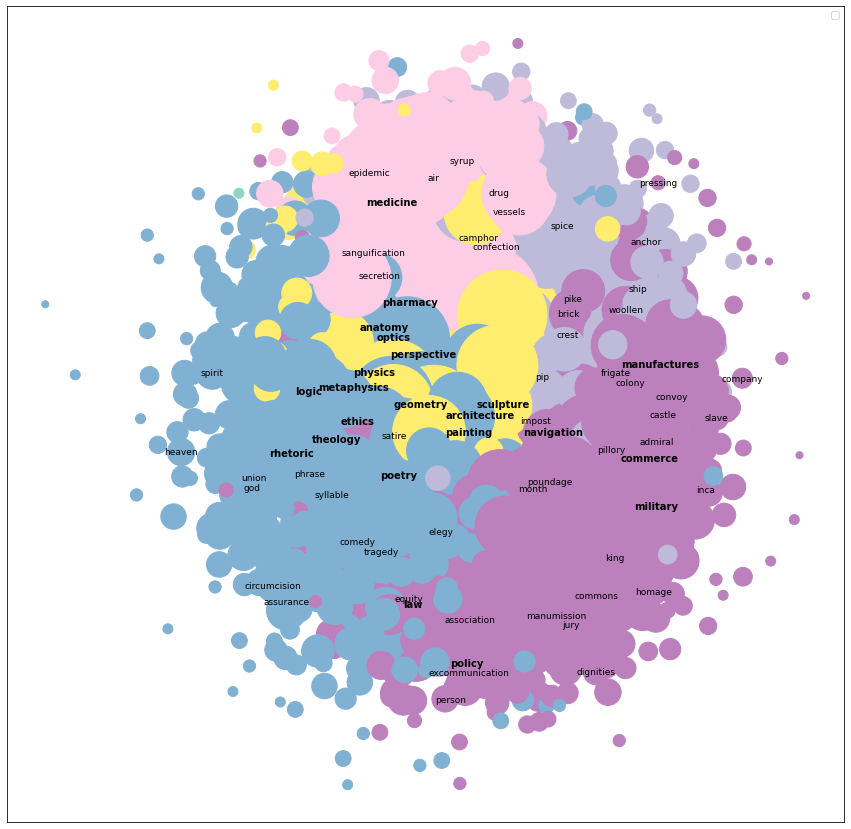

In [60]:
plt.figure(figsize=(20,20))
g = G.subgraph([label for idx, (label, _) in enumerate(pos.items()) if label in linkOrder and label not in cutList and idx%10==0 or label in addList]) # if "topic " in topic])
nx.draw_networkx_labels(g, pos,  font_color='black', font_size=10, horizontalalignment='left', font_weight='bold' )
g = G.subgraph([term for idx, term in enumerate(pos.keys()) if term not in linkOrder and term not in cutList and idx%38==0 or term in addSmall])
nx.draw_networkx_labels(g, pos, font_size=9) #label_pos=1

nx.draw_networkx_nodes(G, pos, nodelist=nodes, cmap = plt.get_cmap(matplotlib.cm.Set3), node_color =values, node_size=degrees, 
                       label=None)#,  vmin=100, vmax=300) #, alpha=0.2)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
f = plt.figure(1)

#plt.savefig('cycloNetwork-623.eps', dpi=400, bbox_inches='tight', format='png') ### If you want to save the image.
plt.show()

## Measuring Semantic Similarity between Linked Terms

## Analyze the vector similarity scores between discipline headers and entries. 
This analysis measures the semantic similarity between successive terms in Chambers's catalog of linked entries, which as I note above represent distilled courses through the cross-references of the _Cyclopaedia_. The semantic similarity scores are averaged to observe which arts and sciences gather together very similar terms and which ones bring together disparate ones. 

Iterate through the headings and linked entries and store the list of scores for the terms in each field.

In [66]:
from collections import defaultdict 
termSimScore = defaultdict(list)
for k, v in headings.items():
    newList = list(k) + v
    for idx, term in enumerate(newList): 
        if len(newList)> idx+1: 
            if term in rest_model.wv.index_to_key and newList[idx+1] in rest_model.wv.index_to_key: 
                sim = rest_model.wv.similarity(term, newList[idx+1])
                termSimScore[k].append(sim) ## This is a dictionary with the art and science headings as keys and lists 
                                            ## of similarity scores as values. 

In [68]:
linkSimDict = defaultdict(list)
count = 0
for k in headings.keys():
    count=0
    while count+1 < len(headings[k]):
        if headings[k][count] in rest_model.wv and headings[k][count+1] in rest_model.wv:
            linkSimDict[k].append(rest_model.wv.similarity(headings[k][count], headings[k][count+1]))
            count = count+1
        else: 
            count = count+1

Create a dictionary with a list of all the succesive entries and their similarity scores as tuples. 

In [75]:
linkPairsDict = defaultdict(list)
for k in headings.keys():
    count=0
    while count+1 < len(headings[k]):
        if headings[k][count] in rest_model.wv and headings[k][count+1] in rest_model.wv:
            linkPairsDict[k].append((headings[k][count], headings[k][count+1], rest_model.wv.similarity(headings[k][count], headings[k][count+1])))
            count+=1
        else: 
            count+=1

Observe the semantic similarity scores for entry pairs in different arts and sciences. 

In [73]:
# Here is the list of all the arts and sciences in the Cyclopaedia.
print(linkPairsDict.keys())

dict_keys(['heraldry', 'rhetoric', 'metaphysics', 'ethics', 'commerce', 'phonics', 'manage', 'law', 'manufactures', 'navigation', 'anatomy', 'pharmacy', 'logic', 'military', 'minerology', 'physics', 'astronomy'])


In [76]:
### Here's an example for metaphysics.
print(sorted(linkPairsDict['metaphysics'], key=lambda x:x[2], reverse=True))

[('ens', 'essence', 0.7483233), ('essence', 'existence', 0.7242199), ('abstraction', 'perceptions', 0.6758591), ('knowledge', 'science', 0.6651874), ('probability', 'certainty', 0.6325171), ('understanding', 'mind', 0.5815788), ('mind', 'apprehension', 0.5405694), ('certainty', 'fallacy', 0.47088075), ('perceptions', 'substance', 0.46972373), ('whole', 'part', 0.4628353), ('science', 'art', 0.45517325), ('power', 'act', 0.4218946), ('imagination', 'reason', 0.40183055), ('species', 'difference', 0.39224583), ('fallacy', 'nominal', 0.38629237), ('experience', 'probability', 0.35679862), ('apprehension', 'judgment', 0.35384756), ('quantity', 'quality', 0.33203983), ('difference', 'proper', 0.3202812), ('infinity', 'universal', 0.3052817), ('existence', 'power', 0.26493144), ('circumstance', 'external', 0.226623), ('reason', 'wit', 0.2262153), ('external', 'knowledge', 0.22613984), ('proper', 'opposite', 0.21339533), ('art', 'experience', 0.2130212), ('act', 'understanding', 0.17697322), 

These are the lists of the arts and sciences with the highest and lowest average similarity scores, respectively. 

In [72]:
linkSimAvgLst = [] 
for k in linkSimDict.keys():
    if len(linkSimDict[k])>19: 
        linkSimAvgLst.append((k, np.mean(linkSimDict[k])))#*len(simDict[k])))
print(sorted(linkSimAvgLst, key=lambda x:x[1], reverse=True)[:15])
print()
print(sorted(linkSimAvgLst, key=lambda x:x[1], reverse=True)[15:30])

[('anatomy', 0.558103), ('pharmacy', 0.5290826), ('logic', 0.5278406), ('military', 0.5128383), ('minerology', 0.5107015), ('physics', 0.48932475), ('astronomy', 0.4858624), ('agriculture', 0.47630757), ('chemistry', 0.47546372), ('medicine', 0.4707803), ('geometry', 0.45095462), ('poetry', 0.448382), ('phytology', 0.43724763), ('grammar', 0.41164246), ('theology', 0.40508753)]

[('policy', 0.39458907), ('navigation', 0.39242336), ('manufactures', 0.38930866), ('architecture', 0.38605365), ('zoology', 0.3807763), ('gardening', 0.36723098), ('law', 0.35196996), ('manage', 0.3485692), ('phonics', 0.34710756), ('commerce', 0.33342427), ('ethics', 0.32795247), ('metaphysics', 0.31301206), ('rhetoric', 0.28950194), ('heraldry', 0.22180504)]
